## self-sustainable Save a custom PyTorch Model

[tutorial] https://huggingface.co/docs/transformers/en/custom_models

In [1]:
from transformers import AutoModel
from model import AudioMAEConfig, PretrainedAudioMAEEncoder

C:\Users\dslee\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Registering a model with custom code to the auto classes
AudioMAEConfig.register_for_auto_class()
PretrainedAudioMAEEncoder.register_for_auto_class()

In [3]:
# create instances
config = AudioMAEConfig()
model = PretrainedAudioMAEEncoder(config)

In [4]:
# load the uploaded model
pretrained_model = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)
pretrained_state_dict = pretrained_model.state_dict()

c:\Users\dslee\anaconda3\envs\sound_effect_variation_generation\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dslee\.cache\huggingface\hub\models--hance-ai--audiomae. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
A new version of the following files was downloaded from https://hf-proxy.rob

In [6]:
# load the pretrained weights
model.load_state_dict(pretrained_state_dict)

<All keys matched successfully>

In [7]:
with open('token.txt', 'r') as file:
    token = file.read().strip()

model.push_to_hub('hance-ai/audiomae', token=token)  # put your token

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/hance-ai/audiomae/commit/b17872cba2bf72c64b0631f99a469b71c916a7e1', commit_message='Upload PretrainedAudioMAEEncoder', commit_description='', oid='b17872cba2bf72c64b0631f99a469b71c916a7e1', pr_url=None, pr_revision=None, pr_num=None)

Recommend git fetching and pulling so that the uploaded model is synced locally too.

***

In [12]:
from transformers import AutoModel

# load the uploaded model
device = 'cpu'
model = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True).to(device)

In [13]:
# forward
z = model('.sample_sound/baby_coughing.wav')
print('z.shape:', z.shape)

z.shape: torch.Size([768, 8, 64])


### Sanity check

In [3]:
from sklearn.decomposition import PCA
import numpy as np
from einops import rearrange

def reduce_dimension(z_ssl):
    d, h, w = z_ssl.shape
    
    z_ssl = rearrange(z_ssl, 'd h w -> (h w) d')
    pca = PCA(n_components=8)
    z_ssl_pca = pca.fit_transform(z_ssl)
    z_ssl_pca = rearrange(z_ssl_pca, '(h w) d -> d h w', h=h, w=w)
    return z_ssl_pca, pca.explained_variance_ratio_

z_ssl_pca, explained_variance_ratio = reduce_dimension(z.detach().numpy())  # (d h w)
n_pca_components = z_ssl_pca.shape[0]
print('z_ssl_pca.shape:', z_ssl_pca.shape)
print('explained_variance_ratio:', np.around(explained_variance_ratio, 2))

z_ssl_pca.shape: (8, 8, 64)
explained_variance_ratio: [0.1  0.07 0.07 0.05 0.04 0.03 0.03 0.02]


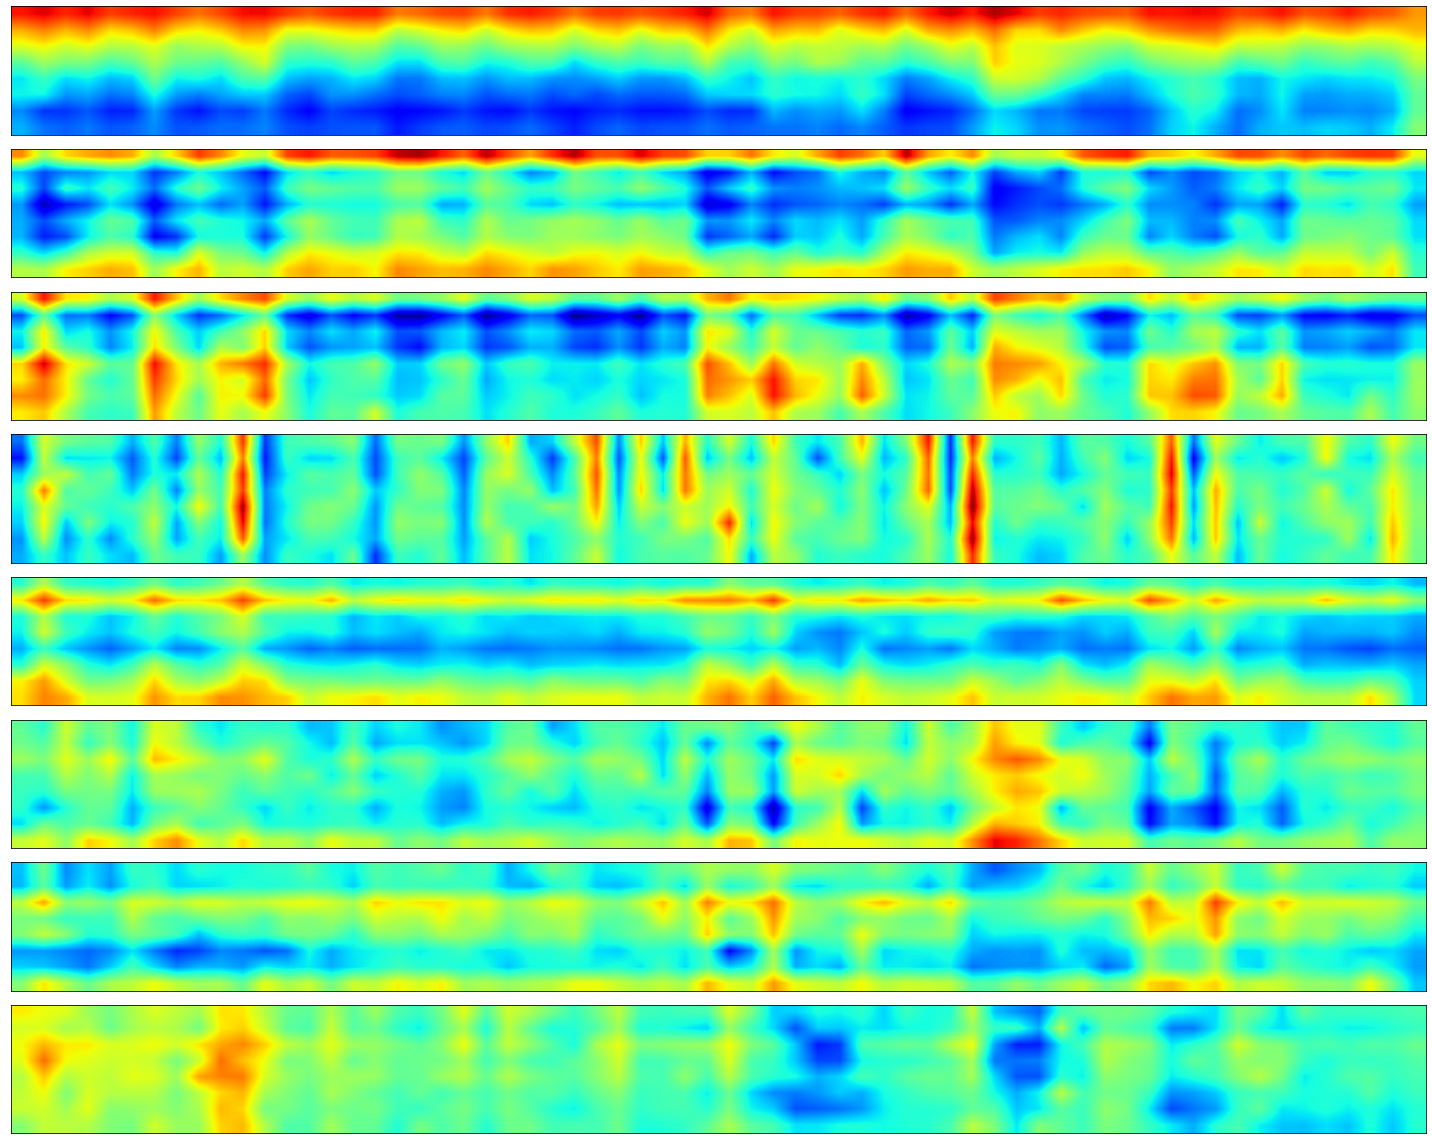

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n_pca_components, 1, figsize=(20, 2*n_pca_components))
for c, ax in enumerate(axes):
    # ax.set_title(f'pca channel idx:{c}', fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(z_ssl_pca[c], cmap='jet', aspect='auto', interpolation='bilinear', 
              vmin=z_ssl_pca.min(), vmax=z_ssl_pca.max(),
              )
    ax.invert_yaxis()
plt.tight_layout()
plt.show()